#### What is Routing in LangGraph?
Routing in LangGraph refers to the ability to conditionally determine which node to execute next based on the current state or the output of a node. This is typically implemented using:

- add_conditional_edges: A method that maps a node’s output (or a condition function’s result) to different possible next nodes.

- State: The workflow’s state can store variables that influence routing decisions.

- Condition Functions: Functions that evaluate the state or node output to decide the next step.

#### Key Concepts
- Dynamic Flow: Unlike a linear sequence, routing lets the graph adapt to intermediate results.

- Condition Logic: You define rules (e.g., "if this, go here; if that, go there").

- Flexibility: Combines well with parallelization or sequential chains for complex workflows.


In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


# Initialize LLM
llm = ChatGroq(
    temperature=0,
    model_name="llama3-70b-8192"
)
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.074285714, 'prompt_time': 0.000120108, 'queue_time': 0.274572942, 'total_time': 0.074405822}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'finish_reason': 'stop', 'logprobs': None}, id='run--b878b74c-e727-47b6-8ff4-e68fd10cb69c-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})

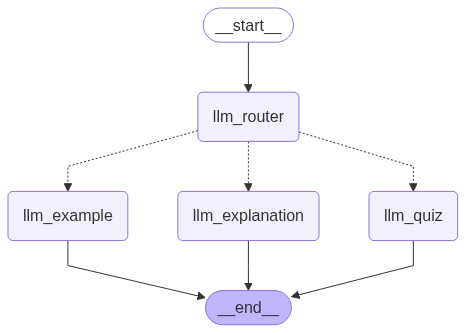

In [14]:
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import Runnable
from IPython.display import Image, display

# 1. Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["explanation", "quiz", "example"] = Field(
        description="The next step in the routing process"
    )

# 2. Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

# 3. Shared state for graph execution
class State(TypedDict):
    input: str
    decision: str
    output: str

# 4. Nodes

def llm_explanation(state: State):
    """Provide a detailed explanation."""
    print("llm exaplanation")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_quiz(state: State):
    """Generate a quiz based on the topic."""
    print("llm quiz")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_example(state: State):
    """Provide an example."""
    print("llm example")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_router(state: State):
    """Route the input to explanation, quiz, or example based on the user's query."""
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to either explanation, quiz, or example based on user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )
    return {"decision": decision.step}

# 5. Routing Logic Function
def route_decision(state: State):
    if state["decision"] == "explanation":
        return "llm_explanation"
    elif state["decision"] == "quiz":
        return "llm_quiz"
    elif state["decision"] == "example":
        return "llm_example"

# 6. Build and Compile Workflow
router_builder = StateGraph(State)
router_builder.add_node("llm_explanation", llm_explanation)
router_builder.add_node("llm_quiz", llm_quiz)
router_builder.add_node("llm_example", llm_example)
router_builder.add_node("llm_router", llm_router)

router_builder.add_edge(START, "llm_router")
router_builder.add_conditional_edges(
    "llm_router",
    route_decision,
    {
        "llm_explanation": "llm_explanation",
        "llm_quiz": "llm_quiz",
        "llm_example": "llm_example",
    },
)
router_builder.add_edge("llm_explanation", END)
router_builder.add_edge("llm_quiz", END)
router_builder.add_edge("llm_example", END)

router_workflow = router_builder.compile()

# Optional: Visualize the Graph
display(Image(router_workflow.get_graph().draw_mermaid_png()))


In [15]:
state = router_workflow.invoke({"input": " Example on langchain ?"})
print(state["output"])


llm example
Langchain is a fascinating tool that enables you to create conversational AI models that can engage in discussions, answer questions, and even generate text based on a given prompt. Here's an example of how you can use Langchain:

**Example: Creating a Conversational AI Model**

Let's say we want to create a conversational AI model that can discuss the topic of space exploration. We'll use Langchain to train a model that can respond to user input and engage in a conversation.

**Step 1: Prepare the Data**

We'll need a dataset of text related to space exploration. This can be a collection of articles, books, or even online forums discussing the topic. Let's assume we have a dataset of 10,000 sentences related to space exploration.

**Step 2: Preprocess the Data**

We'll preprocess the data by tokenizing the sentences, removing stop words, and converting the text to lowercase. This will help the model understand the structure and meaning of the text.

**Step 3: Train the Mod

## 🚀 How It Works as a Whole

1. **User gives input**  
   Example:  
2. **`llm_router()`**  
- Uses a Language Model (LLM) with structured output (Pydantic `Route` schema) to classify the input.
- It chooses one of the following routes:
  - `"explanation"`
  - `"quiz"`
  - `"example"`

3. **`route_decision()`**  
- Checks the classification result from:
  ```python
  state["decision"]
  ```
- Returns the appropriate function name:
  - `"llm_explanation"`  
  - `"llm_quiz"`  
  - `"llm_example"`

4. **The selected node runs**  
- One of `llm_explanation`, `llm_quiz`, or `llm_example` is triggered.
- It processes the input and generates content using the LLM.
- The result is stored in:
  ```python
  state["output"]
  ```

5. **Workflow ends**  
- Final output is available in:
  ```python
  print(state["output"])
  ```

